# Improving performance and low-level distributed computing

## Performance

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64

In [3]:
sns.set_context('notebook', font_scale=1.5)

**Functions to optimize**

In [4]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

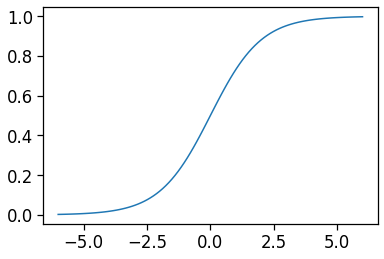

In [5]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [6]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

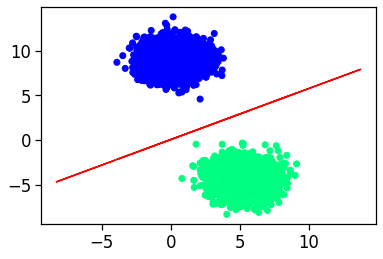

In [7]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. (10 points)

Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. 

In [8]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

**2**. (20 points) 

Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

**3**. (20 points) 

Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate (-a)` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

**4**. (50 points)

Write a program using `spark` to find 5 most common k-mers (shifting windows of length k) in the C. elegans genome. Ignore case when processing k-mers. You can work one line at a time - we will ignore k-mers that wrap around lines. You should write a function that takes a path to FASTA files and a value for k, and returns an key-value RDD of k-mer counts. Remember to strip comment lines that begin with '>' from the anlaysis. 

**Note**: 

- Use the low level RDD interface for this exercise.
- The textFile method takes an optional second argument for controlling the number of partitions of the file. By default, Spark creates one partition for each block of the file (blocks being 128MB by default in HDFS), but you can also ask for a higher number of partitions by passing a larger value. Please set this paramter to 60 - it will speed up processing.

**Check**: Use the C. elegans genome at `/data/c_elegans/*fa`. You should get 

```
[
(u'ATATATATATATATATATAT', 2168), 
(u'TATATATATATATATATATA', 2142), 
(u'CTCTCTCTCTCTCTCTCTCT', 1337), 
(u'TCTCTCTCTCTCTCTCTCTC', 1327), 
(u'AGAGAGAGAGAGAGAGAGAG', 1007)
]
```

**Instructions for local Spark installation**

If you are doing this on your own machine, you can download the DNA sequence from 

ftp://ftp.wormbase.org/pub/wormbase/releases/WS272/species/c_elegans/PRJNA13758/c_elegans.PRJNA13758.WS272.genomic.fa.gz

The results might be slightly different since this may be a newer consensus sequence than the one on HDFS in the Docker container.

You will probably need to also load SparkContext explicitly if doing this on your laptop.

```python
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.SparkContext()
```